In [ ]:
import re
import random
!pip install pymorphy2
import pymorphy2

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.text as text
import matplotlib.cm as cm
%matplotlib inline

# Нужно раскоментировать чтобы работало построение разного рода графиков,
# но тогда на матрице ошибок возникают лишние линии
#import seaborn as sns; sns.set()

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV


     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 8.2MB 13.4MB/s 


In [ ]:
import itertools
pd.options.display.width = 0
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 11)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
gc_path = r"/content/gdrive/My Drive/Colab Notebooks/"

In [ ]:
df = pd.read_excel(gc_path+'mails.xlsx')
print(df['class'].unique())
df['TYPE_HOTLINE'].unique()


[1 6 5 2 3 4 8 7]


array([2, 1, 3])

In [ ]:
# Меняем наименование столбца только для удобства
df.rename(columns={'CLASS_': 'lbl'}, inplace=True)
# Для удобства добавляем два столбца с наименованиями классов и каналов поствупления обращений.
cls_dic = {1:['Условия подачи','Условия подачи документов, сроки, документы, места, льготы'],
           2:['Проходной и допустимый балл','Минимальный проходной балл и Минимальный балл для подачи заявления'],
           3:['Достижения','Индивидуальные достижения.'],
           4:['Общежития','Общежития'],
           5:['Вступительные испытания','Вступительные испытания, экзамены, кто может поступать и сдавать экзамены'],
           6:['Перевод','Перевод с направления на направление'],
           7:['Аспирантура','Вопросы по аспирантуре'],
           8:['Регистрация','Регистрация в электронных системах'],
           }
hlt_dic = {1:'ONLINE приёмная',
           2:'Очная приемная',
           3:'Приёмная аспирантуры'
           }

df['cls_name'] = df['class'].map(lambda x: cls_dic[x][0])
df['hlt_name'] = df.TYPE_HOTLINE.map(lambda x: hlt_dic[x])
df.head()

,Unnamed: 0,CONTENT,TYPE_HOTLINE,class,cls_name,hlt_name
0,0,Здравствуйте! Поступила в ваш институт на бюдж...,2,1,Условия подачи,Очная приемная
1,1,Здравствуйте! Я прошла конкурс по трем дисципл...,2,6,Перевод,Очная приемная
2,2,Здравствуйте! Скажите пожалуйста могу ли я под...,2,1,Условия подачи,Очная приемная
3,3,Здравствуйте! Где взять и куда подать заявлени...,2,1,Условия подачи,Очная приемная
4,4,Здравствуйте! Есть два высших образования (пла...,2,1,Условия подачи,Очная приемная


In [ ]:
cls_list = []
for i in range(1,len(cls_dic)+1):
  cls_list.append(cls_dic[i][0])

In [ ]:
df.shape

(588, 6)

### Анализ, визуализация и сбалансированность датасета

cls_name
Аспирантура                      5
Вступительные испытания        155
Достижения                      29
Общежития                       28
Перевод                         42
Проходной и допустимый балл     24
Регистрация                     16
Условия подачи                 289
Name: cls_name, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


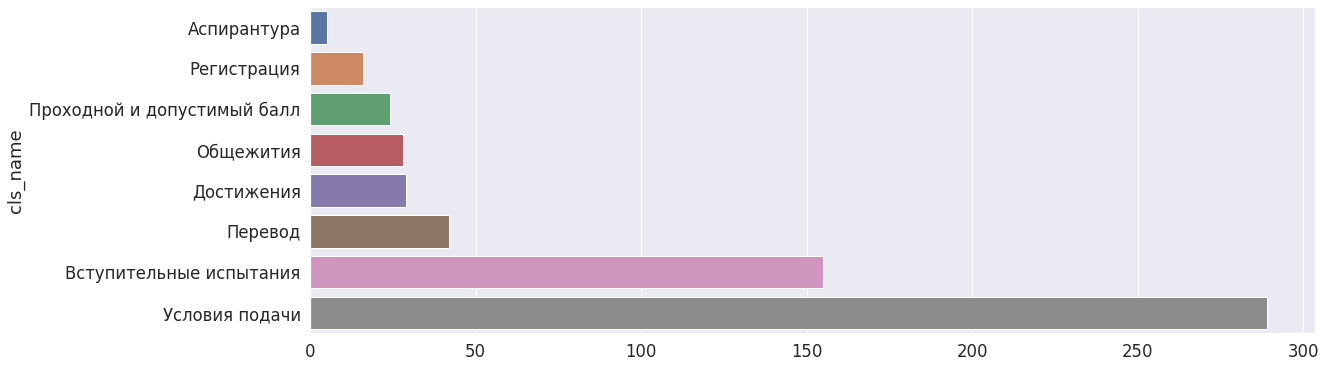

In [ ]:
g = df.groupby('cls_name')['cls_name'].count().sort_values()
print(df.groupby('cls_name')['cls_name'].count())
sns.set(font_scale=1.5)
f, ax = plt.subplots(figsize=(18, 6))
sns.barplot(g.values, g.index, orient='h')
#f.savefig('Data\\fig_1.png', bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


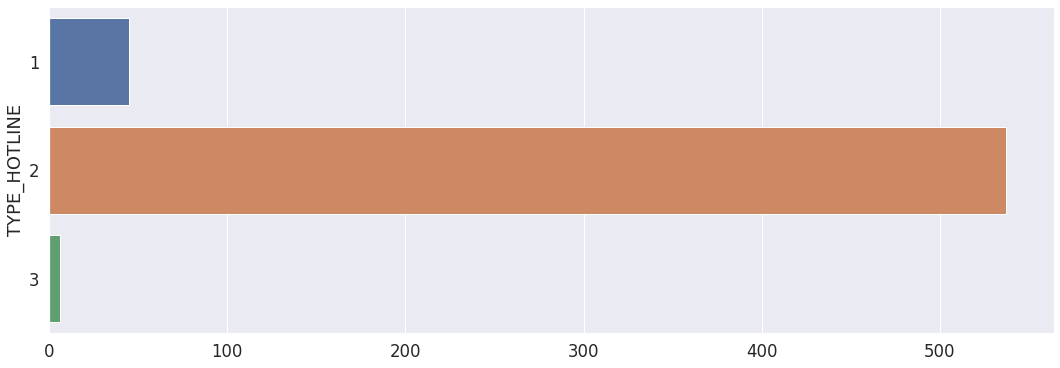

In [ ]:
g = df.groupby('TYPE_HOTLINE')['TYPE_HOTLINE'].count().sort_values()
sns.set(font_scale=1.5)
f, ax = plt.subplots(figsize=(18, 6))
sns.barplot(g.values, g.index, orient='h')

# Задача 1. Подготовка данных
Предобработка текста писем: удаление из текста лишней информации, которая не нужна для получения основной мысли сообщения и классификации его.

In [ ]:
Ваш код для обработки текста, результат необходимо сохранить в df['text']

#### Приведение слов в нормальную форму

In [ ]:
def morphan(word, morph):
    '''
    Приведение слов в нормальную форму, удаление числительных и ФИО.
    '''
    word = del_punct(word).strip()
    p = morph.parse(word)[0]

    word_new = word
    if (not 'Surn' in p.tag) and (not 'Name' in p.tag) and (not 'Patr' in p.tag) and ('NOUN' in p.tag):
        #существительное не ФИО
        word_new = p.normal_form
    elif 'Surn' in p.tag:
        word_new = 'ФАМИЛИЯ'
    elif 'Name' in p.tag:
        word_new = 'ИМЯ'
    elif 'Patr' in p.tag:
        word_new = 'ОТЧЕСТВО'


    elif ('INFN' in p.tag) or ('VERB' in p.tag): #глагол
        word_new = p.normal_form

    elif ('ADJF' in p.tag) or ('ADJS' in p.tag) or ('COMP' in p.tag): #прилагательное
        word_new = p.normal_form


    elif ('PRTF' in p.tag) or ('PRTS' in p.tag) or ('GRND' in p.tag): #причастие, похоже на глагол
        word_new = p.normal_form

    elif ('ADVB' in p.tag) or ('NPRO' in p.tag) or ('PRED' in p.tag) or ('PREP' in p.tag) or ('CONJ' in p.tag) or ('PRCL' in p.tag) or ('INTJ' in p.tag):
        # предлоги, местоимения и пр.
        word_new = p.normal_form

    elif ('NUMR' in p.tag) or ('NUMB' in p.tag) or ('intg' in p.tag): # числительные NUMB,intg
        word_new = ''

    else:
        word_new = word
    return word_new

def normtext(txt, morph):
    '''
    Возвращает текст из слов в нормальной форме
    '''
    return str(' '.join([morphan(x, morph) for x in txt.split()]))


In [ ]:
morph = pymorphy2.MorphAnalyzer()

In [ ]:
df['text'] = df.text.map(lambda x: normtext(x, morph))

In [ ]:
# Сохраняем обработанные данные
df.to_excel(gc_path+r'Data/df_prep.xlsx', index=False)

# Задача 2. ML - Классификация
Основная задача (обязательная для решения). Разработать программу для классификации обращений (писем).

In [ ]:
# Т.к. вопрорсов по аспирантуре мало, и в них в основном встречается подстрока 'аспирант', то можно записи проклассифицировать по наличию этой подстроки

def find_aspirant(txt):
    '''
    Возвращает True если в тексте есть слово, начинающееся на 'аспирант'
    '''
    return 'аспирант' in [x[:8] for x in txt.split()]

#### Подбор параметра

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df['class'], random_state=42, test_size=0.3)

tfv = TfidfVectorizer()  # Функция получения векторного представления
X_train = tfv.fit_transform(X_train)
X_test = tfv.transform(X_test)

param_grid = {'C': [1.,10.0]}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3)

grid_search.fit(X_train, y_train)

grid_search.score(X_test, y_test)

grid_search.best_params_

{'C': 10.0}

In [ ]:
def classifier(X_train, y_train, C=10.):
    '''
    Возвращает обученный классификатор и векторизатор.
    '''

    tfv = TfidfVectorizer()
    X_train = tfv.fit_transform(X_train)

    clf = LogisticRegression(C=C)
    clf = clf.fit(X_train, y_train)

    return tfv, clf

def predictor(text, clf, tfv):
    '''
    text - классифицируемый текс
    clf - обученный классификатор
    tfv - обученный векторизатор

    '''
    X_test = tfv.transform([text])

    pred = clf.predict(X_test)

    return pred[0]

In [ ]:
# Обучение
X_train, X_test, y_train, y_test = train_test_split(df.text, df['class'], random_state=42, test_size=0.3)
tfv, clf = classifier(X_train, y_train, C=10.0)

In [ ]:
# Предсказание
pred_save = []
class_save = []
pred = []
print(X_test.shape)
for nom, txt in enumerate(X_test.values):
    if find_aspirant(txt):
        # УДАЛЕНИЕ "аспирант" по подстроке
        pred_save.append(7)
        del_index = X_test.index.to_numpy()[nom]
        X_test = X_test.drop(index=[del_index])
        class_save.append(y_test[y_test.index==del_index].values[0])
        y_test = y_test.drop(index=[del_index])
    else:
        pred.append(predictor(txt, clf, tfv))
print(X_test.shape)


(177,)
(176,)


In [ ]:
y_test_list = y_test.tolist()
y_test_list.extend(class_save)
pred_list = pred[:]
pred_list.extend(pred_save)

mtrs = metrics.classification_report([cls_dic[x][0] for x in y_test_list], [cls_dic[x][0] for x in pred_list])
print(mtrs)

                             precision    recall  f1-score   support

                Аспирантура       1.00      1.00      1.00         1
    Вступительные испытания       0.98      0.90      0.94        49
                 Достижения       0.71      0.62      0.67         8
                  Общежития       0.45      1.00      0.62         5
                    Перевод       0.50      0.17      0.25         6
Проходной и допустимый балл       1.00      0.27      0.43        11
                Регистрация       1.00      0.25      0.40         8
             Условия подачи       0.81      0.97      0.88        89

                   accuracy                           0.83       177
                  macro avg       0.81      0.65      0.65       177
               weighted avg       0.85      0.83      0.81       177



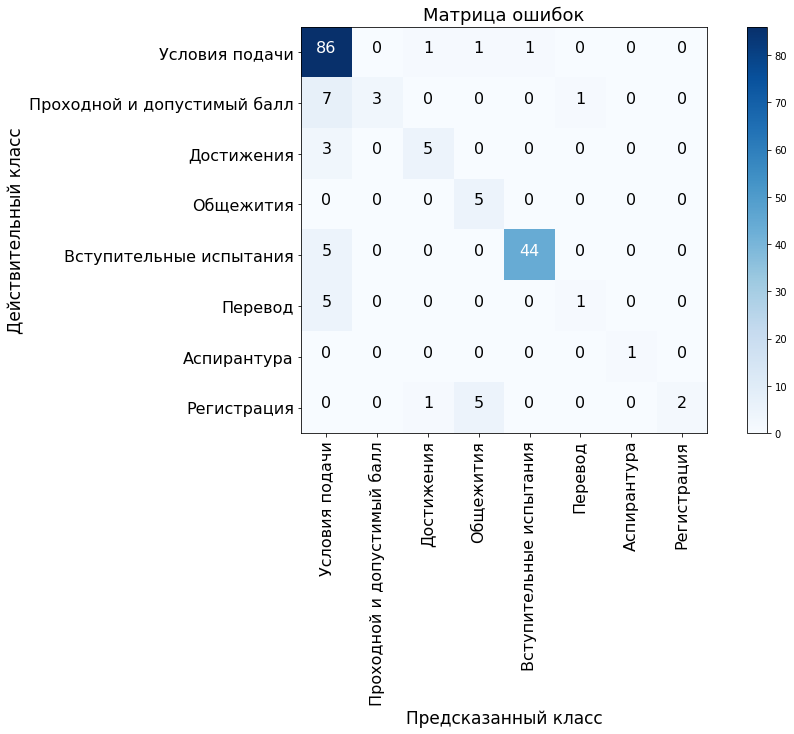

In [ ]:
def plot_confusion_matrix(cm, classes, f_size=16, normalize=False, title='Матрица ошибок', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    plt.figure(figsize=(14,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=f_size + 2)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=f_size - 6)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=f_size)
    plt.yticks(tick_marks, classes, fontsize=f_size)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print("Confusion matrix, without normalization")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=f_size)
    plt.tight_layout()
    plt.ylabel('Действительный класс', fontsize=f_size + 1)
    plt.xlabel('Предсказанный класс', fontsize=f_size + 1)
    plt.show()

# conf_matr = confusion_matrix(y_test_list, pred_list, normalize='true')
conf_matr = confusion_matrix(y_test_list, pred_list)
plot_confusion_matrix(conf_matr, cls_list,  f_size=16)

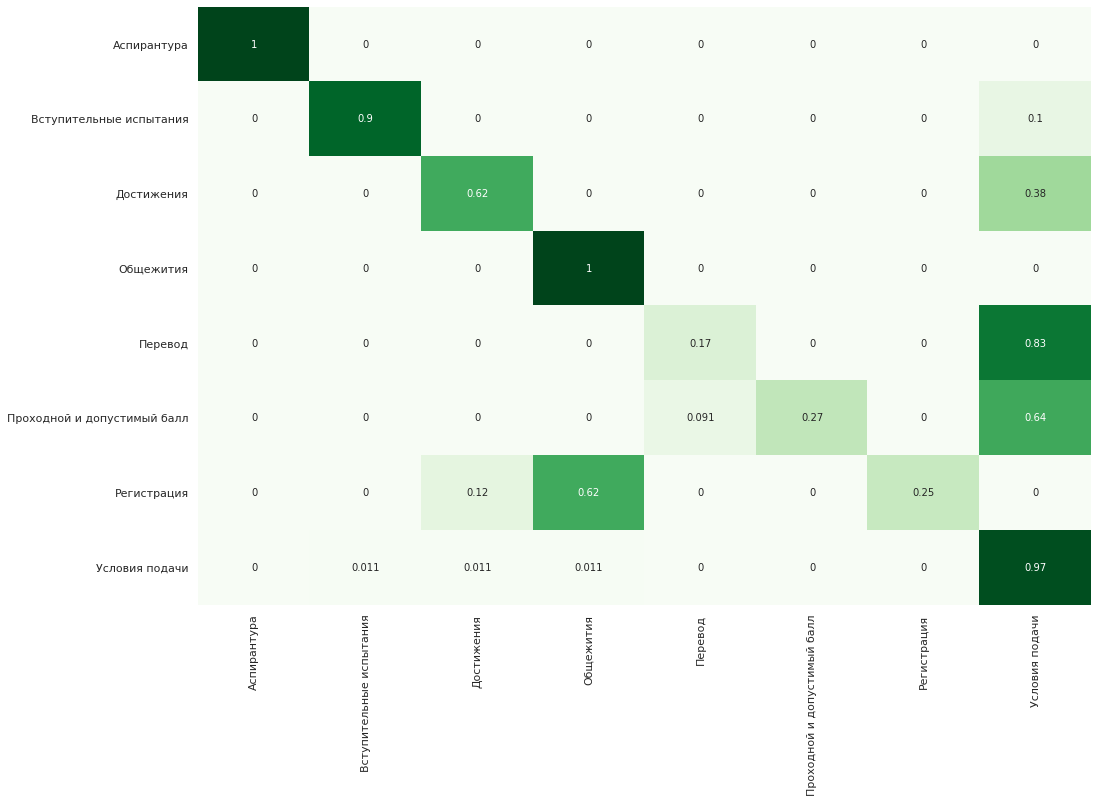

In [ ]:
y_te = [cls_dic[i][0] for i in y_test_list]
y_pr = [cls_dic[i][0] for i in pred_list]
mat = confusion_matrix(y_te, y_pr, normalize='true')
mat = pd.DataFrame(mat, index=np.unique(y_te), columns=np.unique(y_pr))

f, ax = plt.subplots(figsize=(16, 11))
sns_plot = sns.heatmap(mat, annot=True, cbar=False, cmap="Greens")

# Задача 3. RNN - классификация

In [ ]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, LSTM


# LSTM

In [ ]:
# создаем единый словарь (слово -> число) для преобразования
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Преобразуем все описания в числовые последовательности, заменяя слова на числа по словарю.
textSequences = tokenizer.texts_to_sequences(X_train)

In [ ]:
X_train_1, X_vt_1, y_train_1, y_vt_1 = train_test_split(df.text, df['class'], random_state=42, test_size=0.3)
X_valid_1, X_test_1, y_valid_1, y_test_1 = train_test_split(X_vt, y_vt, test_size=0.5, random_state=42)

In [ ]:
# Максимальное количество слов в самом длинном письме
max_words = 0
for desc in df.text.tolist():
    words = len(desc.split())
    if words > max_words:
        max_words = words
print('Максимальное количество слов в самом длинном письме: {} слов'.format(max_words))

total_unique_words = len(tokenizer.word_counts)
print('Всего уникальных слов в словаре: {}'.format(total_unique_words))

maxSequenceLength = max_words

Максимальное количество слов в самом длинном письме: 79 слов
Всего уникальных слов в словаре: 1164


In [ ]:
# Преобразуем описания заявок в векторы чисел

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df.text)

X_train = tokenizer.texts_to_sequences(X_train_1)
X_valid = tokenizer.texts_to_sequences(X_valid_1)
X_test = tokenizer.texts_to_sequences(X_test_1)

X_train = sequence.pad_sequences(X_train, maxlen=maxSequenceLength)
X_valid = sequence.pad_sequences(X_valid, maxlen=maxSequenceLength)
X_test = sequence.pad_sequences(X_test, maxlen=maxSequenceLength)

print('Размерность X_train:', X_train.shape)
print('Размерность X_valid:', X_valid.shape)
print('Размерность X_test:', X_test.shape)

# Преобразуем категории в матрицу двоичных чисел (для использования categorical_crossentropy)

num_classes = df['class'].unique().shape[0]+1

y_train = keras.utils.to_categorical(y_train_1, num_classes)
y_valid = keras.utils.to_categorical(y_valid_1, num_classes)
y_test = keras.utils.to_categorical(y_test_1, num_classes)
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

Размерность X_train: (411, 79)
Размерность X_valid: (88, 79)
Размерность X_test: (89, 79)
y_train shape: (411, 9)
y_valid shape: (88, 9)
y_test shape: (89, 9)


In [ ]:
# максимальное количество слов для анализа
max_features = vocab_size

print(u'Собираем модель...')
model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print (model.summary())

Собираем модель...
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 79)          91956     
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                14336     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 297       
Total params: 106,589
Trainable params: 106,589
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 32
epochs = 25

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_valid, y_valid))

Тренируем модель...
Epoch 1/25
13/13 [==============================] - 5s 137ms/step - loss: 2.1747 - accuracy: 0.3379 - val_loss: 2.0560 - val_accuracy: 0.5000
Epoch 2/25
13/13 [==============================] - 1s 100ms/step - loss: 1.9627 - accuracy: 0.4792 - val_loss: 1.5527 - val_accuracy: 0.5000
Epoch 3/25
13/13 [==============================] - 1s 103ms/step - loss: 1.6405 - accuracy: 0.4562 - val_loss: 1.4766 - val_accuracy: 0.5000
Epoch 4/25
13/13 [==============================] - 1s 99ms/step - loss: 1.5352 - accuracy: 0.4857 - val_loss: 1.4271 - val_accuracy: 0.5000
Epoch 5/25
13/13 [==============================] - 1s 100ms/step - loss: 1.4470 - accuracy: 0.4933 - val_loss: 1.3888 - val_accuracy: 0.5000
Epoch 6/25
13/13 [==============================] - 1s 100ms/step - loss: 1.3548 - accuracy: 0.5374 - val_loss: 1.2867 - val_accuracy: 0.5682
Epoch 7/25
13/13 [==============================] - 1s 101ms/step - loss: 1.2211 - accuracy: 0.6182 - val_loss: 1.2736 - val_accu

In [ ]:
predictions = model.predict(X_test).argmax(axis=1)
y2 = np.array(y_test_1.to_list())
pred2 = np.array(predictions)

In [ ]:
print(classification_report(y2, pred2))

              precision    recall  f1-score   support

           1       0.78      0.93      0.85        45
           2       0.00      0.00      0.00         3
           3       0.40      0.50      0.44         4
           4       0.25      0.50      0.33         2
           5       0.95      0.84      0.89        25
           6       0.50      0.50      0.50         4
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         5

    accuracy                           0.76        89
   macro avg       0.36      0.41      0.38        89
weighted avg       0.71      0.76      0.73        89



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
